In [15]:
# 设置种子
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim

import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [10]:
# 模型使用 conv2D, transformerEncoder, Mean pooling, MLP, sigmoid
class Model(nn.Module):
    def __init__(self, num_classes=2, init_weights=False):
        super(Model, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(1, 8)),
            nn.ReLU(inplace=True),
        )
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=2)
        self.classifier = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, num_classes),
            nn.Linear(num_classes, 1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        x = x.view(-1, 128, 8)
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.squeeze(3)
        x = self.encoder_layer(x)
        x = torch.mean(x, dim=1)
        x = self.classifier(x)
        return x

In [11]:
# 定义超参
class argparse():
    pass

args = argparse()
args.epochs, args.learning_rate, args.train_batch_size, args.test_batch_size = [100, 0.0001, 1024, 512]
args.device, = [torch.device("cuda:0" if torch.cuda.is_available() else "cpu")]

In [12]:
class Dataset_CAR(Dataset):
    def __init__(self, flag='train', csv_paths = []):
        assert flag in ['train', 'test'] # flag 必须是train  test 之间的其中一个
        self.flag = flag
        self.__load_data__(csv_paths)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

    def __load_data__(self, csv_paths: list):
        # 读取 排列按照 train feature train label test feature test label
        self.x = torch.tensor(pd.read_csv(csv_paths[0]).values)
        self.y = torch.tensor(pd.read_csv(csv_paths[1], header = None).values) # 因为 label的表头是没有的，所以使用 header  = None
        print("feature shape: {}, label shape: {}".format(self.x.shape, self.y.shape))

In [13]:
csv_path_train = ['after_aug_X.csv', 'after_aug_y.csv']
train_dataset = Dataset_CAR(flag='train', csv_paths=csv_path_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size = args.train_batch_size, shuffle=True)

feature shape: torch.Size([8034, 1024]), label shape: torch.Size([8034, 1])


In [14]:
csv_path_test = ["K_test_feature.csv", "K_test_y.csv"]
test_dataset = Dataset_CAR(flag='test', csv_paths=csv_path_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size = args.test_batch_size, shuffle=True)

feature shape: torch.Size([7556, 1024]), label shape: torch.Size([7556, 1])


In [16]:
model = Model().to(args.device)
optimizer = optim.Adam(model.parameters(), lr = args.learning_rate)
# 定义二分类交叉熵损失函数
criterion = nn.BCELoss()

train_loss = []
test_loss = []
train_epochs_loss = []
test_epochs_loss = []

In [22]:
# 开始训练
for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx, (data_x, data_y) in enumerate(train_dataloader, 0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        print(data_x)
        print(data_y)
        outputs = model(data_x)
        print(outputs) # output 输出的内容为 nan
        loss = criterion(data_y, outputs)
        loss.backward()
        optimizer.step()

        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())

        if idx %(len(train_dataloader)//2)==0:
            print("epoch={}/{},{}/{}of train, loss={}".format(epoch, args.epochs, idx, len(train_dataloader),loss.item()))
    train_epochs_loss.append(np.average(train_epoch_loss))

    #=====================valid============================

    model.eval()
    test_epoch_loss = []
    for idx, (data_x, data_y) in enumerate(test_dataloader, 0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)

        outputs = model(data_x)

        loss = criterion(data_y, outputs)
        test_epoch_loss.append(loss.item())
        test_loss.append(loss.item())

    test_epochs_loss.append(np.average(test_epoch_loss))

tensor([[-0.0025,  0.0597,  0.0506,  ...,  0.1216, -0.0074, -0.0350],
        [ 0.0525,  0.0105, -0.0526,  ...,  0.0637,  0.0033, -0.0810],
        [ 0.0352, -0.0155,  0.0948,  ..., -0.0268, -0.0254,  0.1201],
        ...,
        [ 0.0352,  0.1406, -0.0010,  ...,  0.1757,  0.1751, -0.0083],
        [ 0.0363, -0.0539,  0.0352,  ...,  0.0657,  0.1251,  0.0177],
        [ 0.1291,  0.0220,  0.0152,  ..., -0.0056, -0.0201, -0.0238]])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<SigmoidBackward0>)
epoch=0/100,0/8of train, loss=nan
tensor([[ 0.1370,  0.0763, -0.0202,  ...,  0.0446,  0.0098, -0.0257],
        [ 0.0843,  0.0333, -0.0535,  ...,  0.0617, -0.0041, -0.0059],
        [ 0.0869,  0.1004, -0.0379,  ...,  0.0213,  0.0743,  0.0509],
        ...,
        [ 0.0330,  0.0655,  0.0597,  ...,  0.0963, -0.0773,  0.0180],
        [

KeyboardInterrupt: 

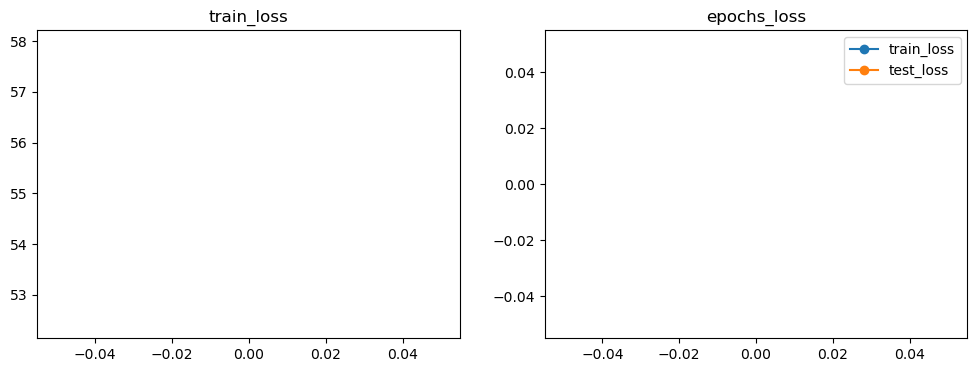

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
plt.plot(test_epochs_loss[1:],'-o',label="test_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

In [25]:
test_true_label = torch.rand(10, 1)
